# Analyzing the vaccination status of the world

### Module imports

In [31]:
import matplotlib.pyplot as plt
from IPython.display import Image
import squarify 
import pandas as pd
import plotly.offline as pyo
import re
import csv
from bs4 import BeautifulSoup
import requests
import pandas as pd
import plotly.express as px

### Static variables


In [32]:
vaccination_data_path = 'data/vaccination-data.csv'
world_population_url = 'https://www.worldometers.info/world-population/population-by-country/'
WHO_regions = { 'AFRO':'The African Region', "EMRO":"The Eastern Mediterranean Region", "SEARO":"The South-East Asia Region", "AMRO":"the Region of the Americas", "WPRO":"The Western Pacific Region", "EURO":"The European Region"}

## Helper functions 

In [33]:
def import_data(path):
    """imports the data from csv into pandas dataframe

    Args:
        path (str): path where the csv file is present

    Returns:
        dataframe: loaded pandas dataframe is returned
    """
    df = pd.read_csv(path)
    return df 

    
def get_world_population(): 
    """obtain the world population using web scrapping

    Returns:
        dataframe: df with country names as index their populations as column
    """
    r = requests.get(world_population_url)

    soup = BeautifulSoup(r.content)
    countries = soup.find_all("table")[0]
    df = pd.read_html(str(countries))[0]

    population_df = pd.DataFrame(df[['Population (2020)','Country (or dependency)']])
    population_df = population_df.rename(columns={'Country (or dependency)':'COUNTRY', 'Population (2020)':'POPULATION'})
    population_df=population_df.set_index('COUNTRY')
    population_df.loc['The United Kingdom'] = population_df.loc['United Kingdom']
    population_df.loc['United States of America'] = population_df.loc['United States']
    population_df.loc['Russian Federation'] = population_df.loc['Russia']
    population_df.loc['Democratic Republic of the Congo'] = population_df.loc['DR Congo']
    population_df.loc['Bolivia (Plurinational State of)'] = population_df.loc['Bolivia']
    population_df.loc['Venezuela (Bolivarian Republic of)'] = population_df.loc['Venezuela']
    population_df.loc['Iran (Islamic Republic of)'] = population_df.loc['Iran']
    population_df.loc['Viet Nam'] = population_df.loc['Vietnam']
    
    return population_df

def plot_box_plot(data, title, xlabel, ylabel, figsize=(5,5)):
    """plot a box plot for the data with parameters specified
    
     Args:
        data (collection): data to be plotted
        title (str) : title of the plot
        xlabel (str) : description of x axis
        ylabel (str) : description of y axis
        figsize (str) : size of the plot

    Returns:
        plot: box plot with the parameters
    """
    plt.figure(figsize=figsize)
    plt.boxplot(data)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    
def plot_world_map(data, iso_column_name, values_column, title, dest_path):
    """plot a box plot for the data with parameters specified
    
     Args:
        data (collection): data to be plotted
        title (str) : title of the plot
        iso_column_name (str) : iso country names to be plotted
        values_column (str) : values to be plotted which determine the intensity
        dest_path (str) : path to save the generate html

    Returns:
        plot: chloropeth which has intensity variation based on values
    """
    fig = px.choropleth(data, locations=iso_column_name,
                    locationmode="ISO-3", color=values_column, scope="world",color_continuous_scale=["orange","yellow","lightgreen","green"])                                        
    fig.update_layout(title = title )
    fig.write_html(dest_path, auto_open=True)


def plot_tree_map(labels, values, title, show_labels=False, scale='M', figsize = (20,5), label_mapping = WHO_regions):
    """plot a box plot for the data with parameters specified
    
     Args:
        labels (collection): labels of data 
        title (str) : title of the plot
        values (str) : values to be plotted
        show_labels (str) : display the label values along with label
        scale (str) : scale of y axis values eg: 'M', 'K' 
        figsize (str) : size of the plot
        label_mapping (str) : mapping of labels variables

    Returns:
        plot: tree map with parameters
    """
    plt.figure(figsize=figsize)
    if scale == 'M':
        perc = ['{:,.0f}'.format(x) + 'M' for x in values/1E6]
    else:
        perc = ['{:,.0f}'.format(x) for x in values]
    lbl = [f'{label_mapping[el[0]]} : {el[1]}' for el in zip(labels, perc)]
    squarify.plot(sizes=values, label=lbl, alpha=1, pad=0.1, text_kwargs={'fontsize':10, 'color':'white','weight':'bold' })
    plt.title(title)
    plt.axis('off')
    plt.show()


## Analysing the Vaccination data 

In [34]:
# Loading the input data
vaccination_df = import_data(vaccination_data_path)

In [35]:
#looking at first few rows of the data
vaccination_df.head()

,COUNTRY,ISO3,WHO_REGION,DATA_SOURCE,DATE_UPDATED,TOTAL_VACCINATIONS,PERSONS_VACCINATED_1PLUS_DOSE,TOTAL_VACCINATIONS_PER100,PERSONS_VACCINATED_1PLUS_DOSE_PER100,PERSONS_FULLY_VACCINATED,PERSONS_FULLY_VACCINATED_PER100,VACCINES_USED,FIRST_VACCINE_DATE,NUMBER_VACCINES_TYPES_USED
0,Afghanistan,AFG,EMRO,REPORTING,2022-03-06,5597130,4952744.0,14.378,12.723,4281934.0,11.000,"Beijing CNBG - BBIBP-CorV,Janssen - Ad26.COV 2...",2021-02-22,4.0
1,Albania,ALB,EURO,REPORTING,2022-02-20,2707658,1284034.0,94.100,45.118,1192155.0,41.889,"AstraZeneca - Vaxzevria,Gamaleya - Gam-Covid-V...",2021-01-13,5.0
2,Algeria,DZA,AFRO,REPORTING,2022-02-20,13631683,7456361.0,31.086,17.004,6076272.0,13.857,"Beijing CNBG - BBIBP-CorV,Gamaleya - Gam-Covid...",2021-01-30,4.0
3,American Samoa,ASM,WPRO,REPORTING,2022-02-16,85050,42212.0,154.084,76.475,37805.0,68.491,"Janssen - Ad26.COV 2-S,Moderna - Spikevax,Pfiz...",2020-12-21,3.0
4,Andorra,AND,EURO,REPORTING,2022-02-13,142420,57797.0,184.300,75.872,53250.0,69.903,"AstraZeneca - Vaxzevria,Moderna - Spikevax,Pfi...",2021-01-20,3.0


### 1. Early bird vaccination countries

Aim :  To check when and where the vaccine administration started

In [36]:
first_dates = vaccination_df.sort_values(by='FIRST_VACCINE_DATE').head()[['COUNTRY','FIRST_VACCINE_DATE']].reset_index(drop=True)
first_dates.style.set_properties(**{'background-color': 'skyblue', 'color': 'white','font-size': '12pt', 'text-align':'centre'})

,COUNTRY,FIRST_VACCINE_DATE
0,China,2020-07-22
1,Bahrain,2020-11-04
2,Lao People's Democratic Republic,2020-11-25
3,Canada,2020-12-14
4,United States of America,2020-12-14


We see that the vaccination administration was first started in July 2020, in china, followed by Bahrain, Laos etc.

### 2. Distribution of number of vaccines types

Aim : To check the distribution of number of vaccine types used across the world

In [37]:
vaccination_df[['COUNTRY','NUMBER_VACCINES_TYPES_USED']].dropna().sort_values(by = 'NUMBER_VACCINES_TYPES_USED', ascending = False).head(3)

,COUNTRY,NUMBER_VACCINES_TYPES_USED
161,Philippines,11.0
146,Nicaragua,9.0
159,Paraguay,8.0


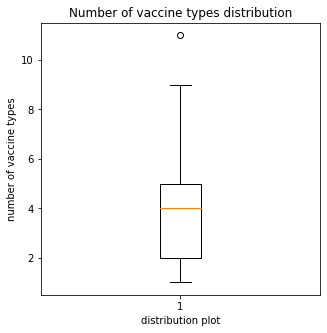

In [38]:
plot_box_plot(vaccination_df['NUMBER_VACCINES_TYPES_USED'].dropna(), 'Number of vaccine types distribution', 'distribution plot', 'number of vaccine types')

We observe that most of the countries use vaccine types > 2 & < 4, the median of the distribution lies around 4 vaccine types.

### 3. Count of Vaccines administered in different WHO regions

Aim : To check how the total vaccines administered count varies in different WHO regions

In [39]:
region_wise_vaccinations = vaccination_df.groupby('WHO_REGION').sum()
region_wise_vaccinations = region_wise_vaccinations.drop('OTHER')

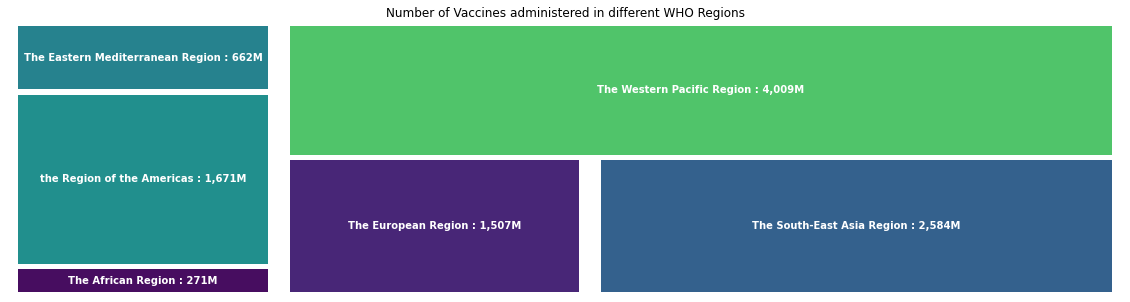

In [40]:
plot_tree_map(region_wise_vaccinations.index, region_wise_vaccinations['TOTAL_VACCINATIONS'], 'Number of Vaccines administered in different WHO Regions', label_mapping = WHO_regions)

We observe that max numbers of vaccines are administered into THe western pacific region which constitutes the countries Australia, Brunei, Cambodia, China, Cook Islands, Fiji, Japan, Kiribati, Laos, Malaysia, Marshall Islands, Micronesia, Mongolia, Nauru, New Zealand, Niue, Palau, Papua New Guinea, Philippines, Samoa, Singapore, Solomon Islands, South Korea, Tonga, Tuvalu, Vanuatu, Vietnam.

### 4. Current status of % vaccinated countries 

Aim : Checking the distribution of %vaccinated persons throughout the world

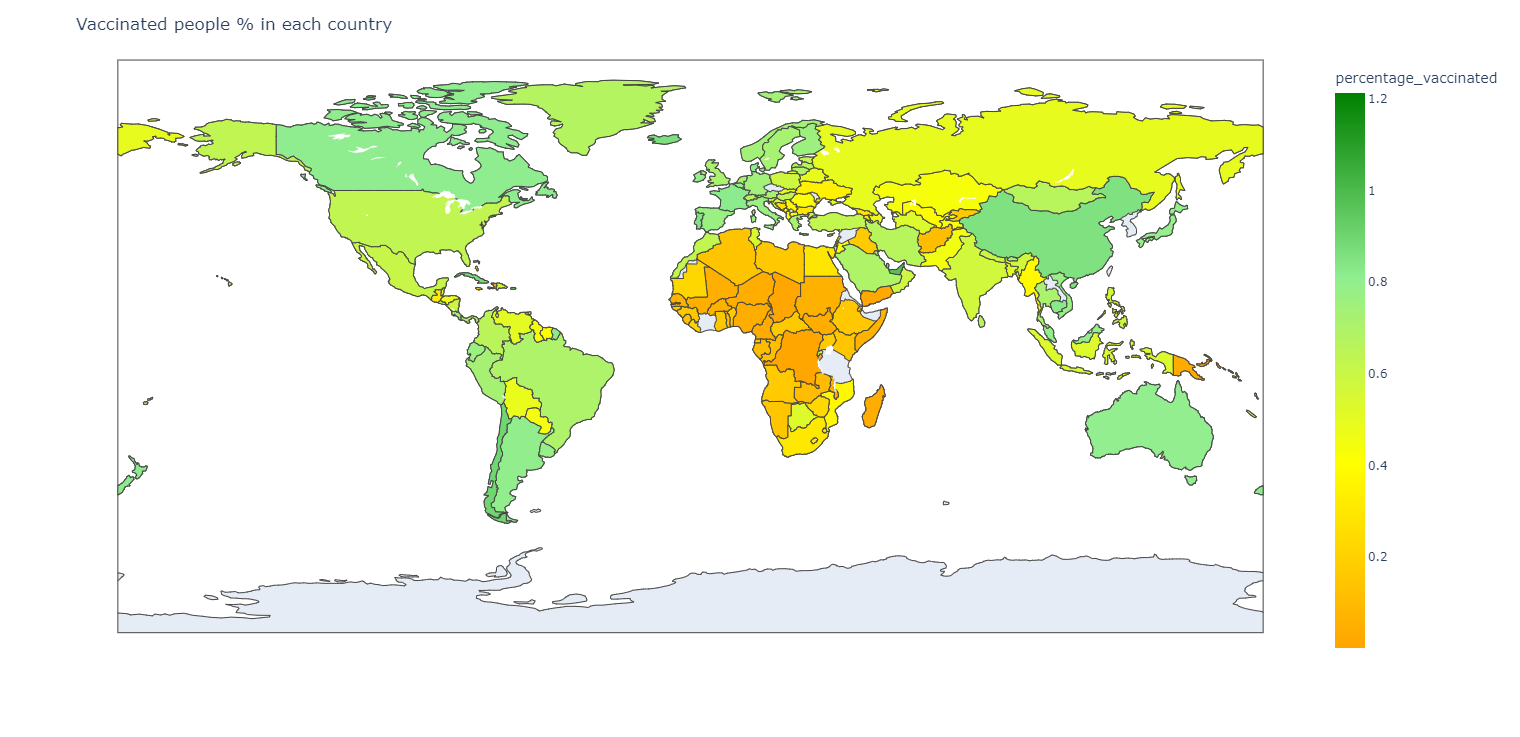

In [41]:
fully_vaccinated_people = vaccination_df[['COUNTRY','ISO3','PERSONS_FULLY_VACCINATED']]
fully_vaccinated_people=fully_vaccinated_people.set_index('COUNTRY')

### web scraping for population
population_df = get_world_population()

combined_fully_vaccinated_people= fully_vaccinated_people.join(pd.DataFrame(population_df['POPULATION']))

combined_fully_vaccinated_people = combined_fully_vaccinated_people.dropna()

combined_fully_vaccinated_people['percentage_vaccinated'] = combined_fully_vaccinated_people['PERSONS_FULLY_VACCINATED']/combined_fully_vaccinated_people['POPULATION']

plot_world_map(combined_fully_vaccinated_people, 'ISO3', 'percentage_vaccinated', "Vaccinated people % in each country", 'artifacts/vaccinated_world.html')
#saved the snap from html reloading the image here 

Image(filename='artifacts/vaccination_world.png')


We observe that other the countries in africa rest of the world's countries have vaccinated > 70% of their population